In [5]:
pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.1/25.1 MB 8.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 16.3 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
#Cargar y mostrar los primeros datos
#Read archive
df_amz = pd.read_csv("amz_uk_price_prediction_dataset.csv") 
# Visualizar primeras filas
df_amz.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [3]:
#Analizar tipos de datos y tamaño
# Tipos de datos
df_amz.dtypes

# Número de filas y columnas
df_amz.shape

(2443651, 9)

In [4]:
#Análisis cruzado (categoría vs best seller)
# 1.1.1. Generar tabla cruzada
crosstab = pd.crosstab(df_amz['category'], df_amz['isBestSeller'], margins=True, margins_name="Total")
crosstab

# 1.1.2. Proporciones
crosstab['ProportionBestSeller'] = crosstab[True] / crosstab['Total']
sorted_crosstab = crosstab.sort_values(by='ProportionBestSeller', ascending=False)
sorted_crosstab


isBestSeller,False,True,Total,ProportionBestSeller
category,,,,
Grocery,9008,556,9564,0.058135
Smart Home Security & Lighting,98,6,104,0.057692
Health & Personal Care,9017,552,9569,0.057686
Mobile Phone Accessories,248,11,259,0.042471
Power & Hand Tools,8353,306,8659,0.035339
...,...,...,...,...
Snowboard Boots,1449,0,1449,0.000000
Bedding Collections,6309,0,6309,0.000000
Blank Media Cases & Wallets,243,0,243,0.000000


In [5]:
#Pruebas estadísticas
# Chi-cuadrado
from scipy.stats import chi2_contingency

crosstab_category_bestseller = pd.crosstab(df_amz['category'], df_amz['isBestSeller'])
chi2_statistic, chi2_p_value, dof, expected = chi2_contingency(crosstab_category_bestseller)
print(f"Chi-squared Statistic: {chi2_statistic:.4f}")
print(f"P-value: {chi2_p_value:.4f}")
# Interpretación en el notebook

# Cramér's V
from scipy.stats.contingency import association
cramers_v = association(crosstab_category_bestseller, method="cramer")
print(f"Cramer's V: {cramers_v:.4f}")
# Interpretación en el notebook

Chi-squared Statistic: 36540.2027
P-value: 0.0000
Cramer's V: 0.1223


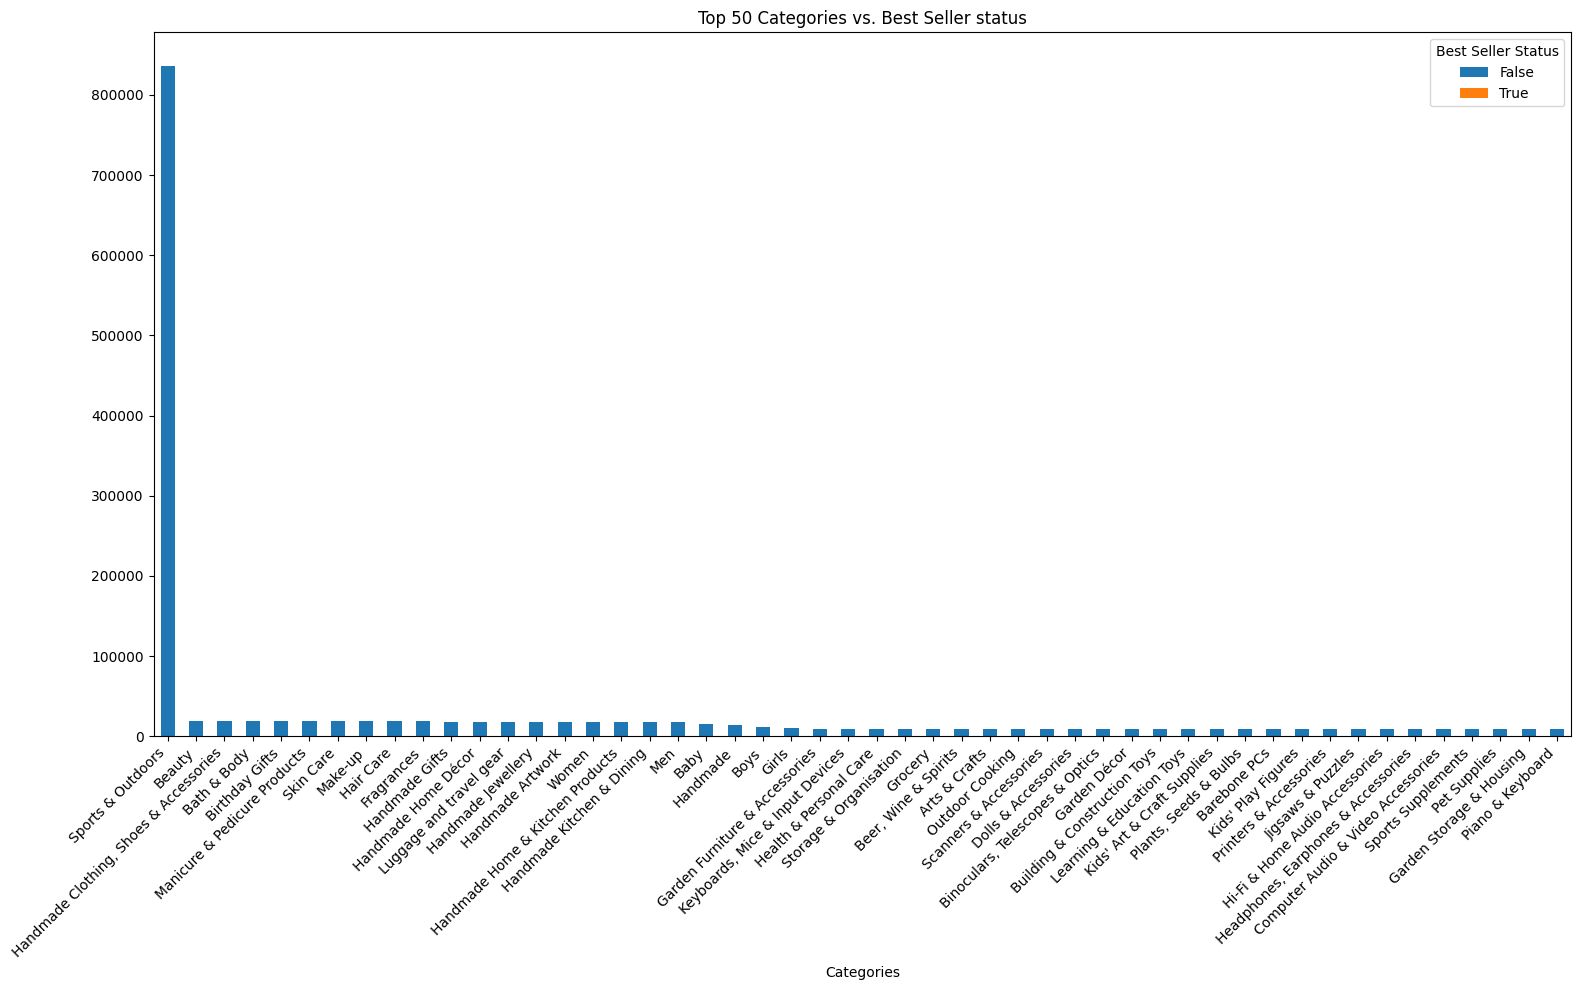

In [6]:
#Visualización: Gráfica de barras apiladas
# Stacked bar chart
top_categories = crosstab_category_bestseller.sum(axis=1).nlargest(50).index  
filtered_crosstab = crosstab_category_bestseller.loc[top_categories]

filtered_crosstab.plot(kind="bar", stacked=True, figsize=(16, 10))
plt.title("Top 50 Categories vs. Best Seller status")
plt.xlabel("Categories")
plt.legend(title="Best Seller Status")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
# Remover outliers de precio (IQR)
def tukeys_test_outliers(data):

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers, lower_bound, upper_bound = tukeys_test_outliers(df_amz["price"])
data_no_outliers_price = df_amz[(df_amz["price"] >= lower_bound) & (df_amz["price"] <= upper_bound)]

/var/folders/4w/mwdnkfkx52791kd5fbxkfnsm0000gn/T/ipykernel_30708/3863360865.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top20_categories_no_outliers_price, x='category', y='price', palette="coolwarm")


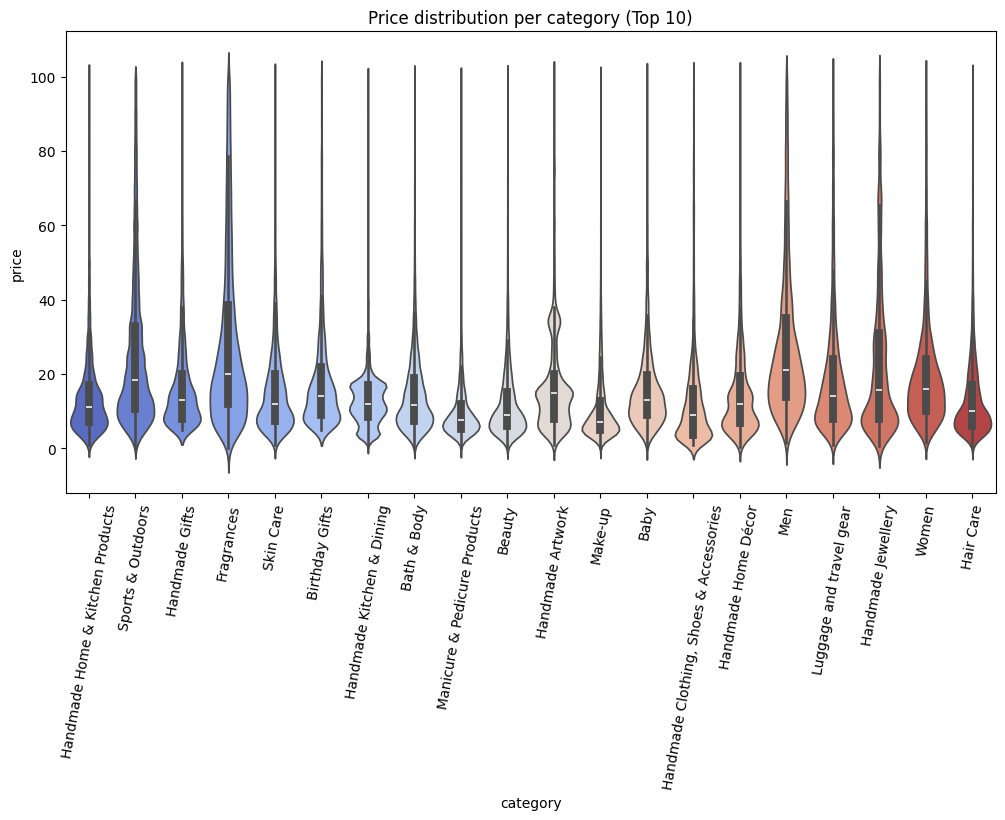

In [11]:
# Violin plot de precios por categoría (Top 20)

top20_categories = df_amz['category'].value_counts().head(20).index
data_top20 = df_amz[df_amz['category'].isin(top20_categories)]
top20_categories_no_outliers_price = data_top20[(data_top20['price']>=lower_bound) & (data_top20['price']<=upper_bound)]

plt.figure(figsize=(12, 6))
sns.violinplot(data=top20_categories_no_outliers_price, x='category', y='price', palette="coolwarm")
plt.title("Price distribution per category (Top 10)")
plt.xticks(rotation=80)
plt.show()


In [12]:
# Medianas y promedios por categoría
# Mediana
median_prices = df_amz.groupby('category')['price'].median()
highest_median_prices_category = median_prices.idxmax()
highest_median_prices_value = median_prices.max()
print(f"Product category with highest median price is '{highest_median_prices_category}' with a median price of {highest_median_prices_value}.")

# Mediana sin outliers
median_prices = data_no_outliers_price.groupby('category')['price'].median()
highest_median_prices_category = median_prices.idxmax()
highest_median_prices_value = median_prices.max()
print(f"Product category with highest median price is '{highest_median_prices_category}' with a median price of {highest_median_prices_value}.")

# Media
mean_prices = df_amz.groupby('category')['price'].mean()
highest_avg_prices_category = mean_prices.idxmax()
highest_avg_prices_value = mean_prices.max()
print(f"Product category with highest average price is '{highest_avg_prices_category}' with an average price of {highest_avg_prices_value}.")

# Media sin outliers
mean_prices = data_no_outliers_price.groupby('category')['price'].mean()
highest_avg_prices_category = mean_prices.idxmax()
highest_avg_prices_value = mean_prices.max()
print(f"Product category with highest average price is '{highest_avg_prices_category}' with an average price of {highest_avg_prices_value}.")

Product category with highest median price is 'Laptops' with a median price of 1042.725.
Product category with highest median price is 'Desktop PCs' with a median price of 74.0.
Product category with highest average price is 'Laptops' with an average price of 1087.987826986755.
Product category with highest average price is 'Motherboards' with an average price of 68.77243243243242.


/var/folders/4w/mwdnkfkx52791kd5fbxkfnsm0000gn/T/ipykernel_30708/3201835004.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_categories_no_outliers_price, x='category', y='price', palette="coolwarm")


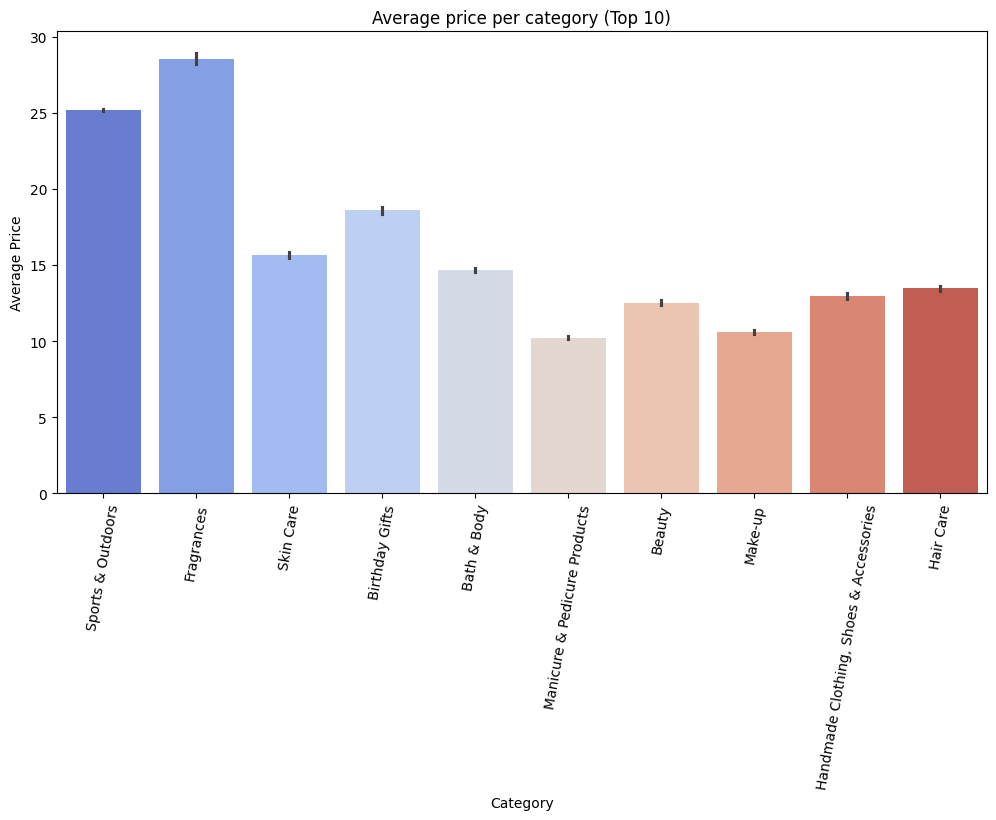

In [13]:
#Bar plot del precio promedio (Top 10)
top10_categories = df_amz['category'].value_counts().head(10).index
data_top10 = df_amz[df_amz['category'].isin(top10_categories)]
top10_categories_no_outliers_price = data_top10[(data_top10['price']>=lower_bound) & (data_top10['price']<=upper_bound)]

plt.figure(figsize=(12, 6))
sns.barplot(data=top10_categories_no_outliers_price, x='category', y='price', palette="coolwarm")
plt.title("Average price per category (Top 10)")
plt.xlabel("Category")
plt.ylabel("Average Price")
plt.xticks(rotation=80)
plt.show()